In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [4]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [5]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

In [6]:
def get_rect_idx(X, left, right, top, bot):
    bound_x = np.logical_and(
        X[:, 0] > left,
        X[:, 0] < right
    )
    bound_y = np.logical_and(
        X[:, 1] > bot,
        X[:, 1] < top
    )
    idx = np.logical_and(bound_x, bound_y)    
    return idx


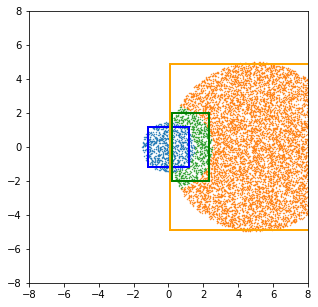

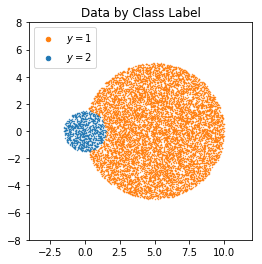

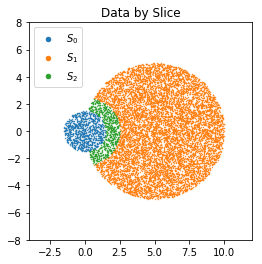

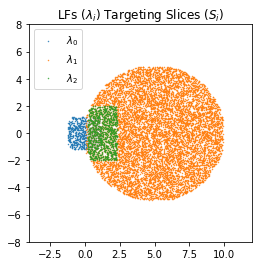

In [7]:
from deathstar_data import generate_deathstar_data, generate_uniform_circle_data, get_circle_idx
from synthetics_utils import shuffle_matrices, lf_circ_idx_for_slice_precision


config = {
    'N': 10000,
    'mus': np.array([[0,  0], [5, 0]]),
    'variances': [1.5, 5],
    'labels': [2, 1],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

    
def generate_pacman_data(config, x_var=None, x_val=None, verbose=False, return_overlap=False):        
    centers = config['mus']
    radii = config['variances']
    
    # normalize proportion of points in each slice based on area of circles
    props = np.square(np.array(radii))
    class_props = props / np.linalg.norm(props)
    N = config['N']
    labels = config['labels']
    lf_metrics = config['lf_metrics'] 
    
    # Set slice 1
    n_per_slice = [int(N*prop) for prop in class_props]
    slice_1 = generate_uniform_circle_data(
        n_per_slice[1], 
        centers[1], 
        radii[1]
    )

    # get idx for slice 0 within slice 1
    slice_0_idx = get_circle_idx(slice_1, tuple(centers[0]), radii[0])
    
    # remove slice 0 idx from slice 1
    slice_1 = slice_1[np.logical_not(slice_0_idx)]
    n_per_slice[1] = len(slice_1)

    
    # Set slice 0
    slice_0 = generate_uniform_circle_data(
        n_per_slice[0], 
        centers[0], 
        radii[0]
    )    
    
    # combine slices
    Xu = [slice_0, slice_1] # data points
    Yu = [label * np.ones(n) for n, label in zip(n_per_slice, labels)] # class labels
    Cu = [i * np.ones(n) for i, n in enumerate(n_per_slice)] # slice labels

    X, Y, C = shuffle_matrices([np.vstack(Xu), np.hstack(Yu), np.hstack(Cu)])
    
    # construct slice 2 as larger circle around slice0 - slice0
    lf2_r_delta = 1.0
    radius_2 = radii[0] + lf2_r_delta
    larger_circ_idx = get_circle_idx(X, tuple(centers[0]), radius_2)
    smaller_circ_idx = get_circle_idx(X, tuple(centers[0]), radii[0])
    slice_2_idx = np.logical_and(larger_circ_idx, np.logical_not(smaller_circ_idx))
    C[slice_2_idx] = 2
    Y[slice_2_idx] = labels[1]
        
    # lf0 LF
    lf0_noise = 0.3
    lf0_top = centers[0][1]+radii[0] - lf0_noise
    lf0_bot = centers[0][1]-radii[0] + lf0_noise
    lf0_left = centers[0][0]-radii[0] + lf0_noise
    lf0_right = centers[0][0]+radii[0] - lf0_noise

    # lf1 LF
    lf1_noise = 0.1
    lf1_top = centers[1][1]+radii[1] - lf1_noise
    lf1_bot = centers[1][1]-radii[1] + lf1_noise
    lf1_left = centers[1][0]-radii[1] + lf1_noise
    lf1_right = centers[1][0]+radii[1] - lf1_noise
    
    # lf2 LF
    lf2_top = centers[0][1] + 2.0
    lf2_bot = centers[0][1] - 2.0
    lf2_left = centers[0][0]+radii[0]-lf2_r_delta - 0.3
    lf2_right = centers[0][0]+radii[0]+lf2_r_delta - 0.2
    
    # TODO/DEBUG: visualize LFs as squares -- refactor 
    L = np.zeros((sum(n_per_slice), 3))
    L[:, 0] = np.ones(sum(n_per_slice))
    fig = plt.figure(figsize=(5, 5))
    for c in np.unique(C):
        plt.scatter(X[C==c,0], X[C==c,1], label=f"$S_{int(c)}$", s=0.2)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    from matplotlib import patches
    rect = patches.Rectangle((lf0_left, lf0_bot), lf0_right-lf0_left, lf0_top-lf0_bot, 
                             fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    rect = patches.Rectangle((lf1_left, lf1_bot), lf1_right-lf1_left, lf1_top-lf1_bot, 
                             fill=False, color='orange', linewidth=2)
    plt.gca().add_patch(rect)
    rect = patches.Rectangle((lf2_left, lf2_bot), lf2_right-lf2_left, lf2_top-lf2_bot, 
                             fill=False, color='green', linewidth=2)
    plt.gca().add_patch(rect)
    
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.show()
    
    # generate label matrix
    L = np.zeros((sum(n_per_slice), 3))
    lf0_idx = get_rect_idx(X, lf0_left, lf0_right, lf0_top, lf0_bot)
    lf1_idx = get_rect_idx(X, lf1_left, lf1_right, lf1_top, lf1_bot)
    lf2_idx = get_rect_idx(X, lf2_left, lf2_right, lf2_top, lf2_bot)
    L[lf0_idx, 0] = labels[0]
    L[lf1_idx, 1] = labels[1]
    L[lf2_idx, 2] = labels[1]

    return X, Y, C, L



X, Y, C, L = generate_pacman_data(
    config
)

# X, Y, C, L = generate_deathstar_data({
#  'N': 10000,
#  'mus': np.array([[-0.5,  0], [5, 0]]),
#  'variances': [3, 7],
# #  'mus': np.array([[0.5,  0], [5, 0]]),
# #  'variances': [2.2, 7],
#  'labels': [2, 1],
#  'props': [0.1, 0.9],
#  'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
#  'mv_normal': False
# })

visualize_data(X, Y, C, L)

In [8]:
np.unique(C, return_counts=True)[1] / C.shape[0]

array([0.08598848, 0.85163148, 0.06238004])

In [9]:
np.unique(L, return_counts=True), np.unique(Y, return_counts=True)

((array([0., 1., 2.]), array([19665, 10873,   722])),
 (array([1., 2.]), array([9524,  896])))

In [10]:
# X = torch.from_numpy(X.astype(np.float32))

In [11]:
# from simulate import simulate, experiment_config
# train_end_idx = int(len(X) * experiment_config["train_prop"])
# dev_end_idx = train_end_idx + int(len(X) * experiment_config["dev_prop"])

# L = L.astype(np.float32)
# Y = Y.astype(np.float32)
# X_train, X_dev, X_test = X[:train_end_idx], X[train_end_idx:dev_end_idx], X[dev_end_idx:]
# Y_train, Y_dev, Y_test = Y[:train_end_idx], Y[train_end_idx:dev_end_idx], Y[dev_end_idx:]
# C_train, C_dev, C_test = C[:train_end_idx], C[train_end_idx:dev_end_idx], C[dev_end_idx:]
# L_train, L_dev, L_test = L[:train_end_idx], L[train_end_idx:dev_end_idx], L[dev_end_idx:]

# # overlap_train, overlap_dev, overlap_test = overlap_idx[:train_end_idx], overlap_idx[train_end_idx:dev_end_idx], overlap_idx[dev_end_idx:]

[0.9859154929577465, 0.9546827794561934, 0.5841584158415841]


(array([ 298.,    0.,   18.,    0.,  209.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  113.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 6655.]),
 array([2.04039992e-04, 3.34925543e-02, 6.67810686e-02, 1.00069583e-01,
        1.33358097e-01, 1.66646611e-01, 1.99935126e-01, 2.33223640e-01,
        2.66512154e-01, 2.99800669e-01, 3.33089183e-01, 3.66377697e-01,
        3.99666211e-01, 4.32954726e-01, 4.66243240e-01, 4.99531754e-01,
        5.32820269e-01, 5.66108783e-01, 5.99397297e-01, 6.32685811e-01,
        6.65974326e-01, 6.99262840e-01, 7.32551354e-01, 7.65839868e-01,
        7.99128383e-01, 8.32416897e-01, 8.65705411e-01, 8.98993926e-01,
        9.32282440e-01, 9.65570954e-01, 9.98859468e-01]),
 <a list of 30 Patch objects>)

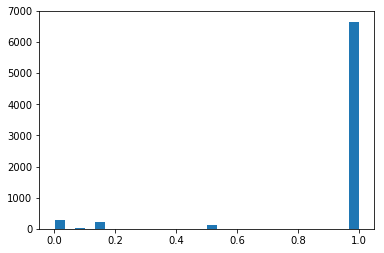

In [12]:
# from metal.contrib.slicing.experiment_utils \
#     import compute_lf_accuracies
# accs = compute_lf_accuracies(L_dev, Y_dev)
# print (accs)

# # accs = np.array([0.9, 0.1]).astype(np.float32)
# from metal.contrib.slicing.experiment_utils import generate_weak_labels
# Y_tilde_accs = generate_weak_labels(L_train, np.array(accs))
# plt.hist(Y_tilde_accs[:, 0], 30)

In [13]:
# Y_tilde_metal = generate_weak_labels(L_train)
# plt.hist(Y_tilde_metal[:, 0], 30)

TypeError: train() got multiple values for keyword argument 'verbose'

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [ ]:
# model_configs = {
#     "AttentionModel": {
#         "base_model_class" : SliceDPModel,
#         "base_model_init_kwargs": {
#             "reweight": True,
#             "r": 5,
#             "slice_weight": 1.0, # NOTE: slice weight 1.0 means we are only backprop on L_head
#             "L_weights": None
#         },
# #         "input_module_class": LinearModule,
#         "input_module_class": MLPModule,
#         "input_module_init_kwargs": {
#             'input_dim': 2,
#             'middle_dims': [5],
#             'bias': True,
#             'output_dim': 5
#          },
#         "train_on_L": True,
#     }
# }

In [ ]:
# from simulate import train_models

# # DEBUG: gt labels for training [prob_1, prob2]
# Y_cat = np.zeros((Y_train.shape[0], 2))
# Y_cat[:,0] = Y_train == 1
# Y_cat[:,1] = Y_train == 2
# Y_cat = Y_cat.astype(np.float32)

# config['accs'] = np.array(accs)
# print (config['accs'])
# # config['accs'] = np.array([1.0, 1.0])
# experiment_config['use_weak_labels_from_gen_model'] = True
# experiment_config['x_var'] = None
# experiment_config['num_trials'] = 1
# experiment_config['verbose'] = True
# experiment_config['visualize_data'] = True
# experiment_config['train_kwargs']['print_every'] = 1
# experiment_config['train_kwargs']['l2'] = 0
# experiment_config['train_kwargs']['lr'] = 0.001
# experiment_config['train_kwargs']['n_epochs'] = 40
# experiment_config['seed'] = 333

# trained_models = train_models(
#     (X_train, X_dev),
#     (Y_tilde_accs, Y_dev),
#     (L_train, L_dev),
#     model_configs,
#     experiment_config["train_kwargs"],
#     verbose=experiment_config["verbose"],
#     seed=experiment_config.get("seed", None)
# )


In [ ]:
# from visualization_utils import compare_prediction_plots
# compare_prediction_plots((X_test, Y_test), trained_models, C_test)

In [ ]:
# from metal.metrics import accuracy_score
# import torch.nn.functional as F

# X_test_L_head = X_test
# L_test_L_head = L_test
# # overlap_test_L_head = overlap_test


# slice_preds = F.sigmoid(
#     trained_models['AttentionModel'].forward_L(X_test_L_head)
# ).detach().numpy()


# preds = (slice_preds > 0.5) * 1
# L_gt = L_test_L_head.copy()
# L_gt[L_gt != 0] = 1
# print ('predicted L distribution:', np.sum(preds, axis=0))
# print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
# print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))
# print ('accuracy over LF2:', accuracy_score(L_gt[:, 2], preds[:, 2]))


# # print ('accuracy over overlap for LF 0:', 
# #        accuracy_score(L_gt[overlap_test_L_head, 0], preds[overlap_test_L_head, 0]))

# # print ('accuracy over overlap for LF 1:', 
# #       accuracy_score(L_gt[overlap_test_L_head, 1], preds[overlap_test_L_head, 1]))


### Compare EndModel to AttentionModel

In [18]:
accs

[0.9859154929577465, 0.9546827794561934, 0.5841584158415841]

In [20]:
model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False,
#         "L_weights": None
        "L_weights": accs
    },
    "Upweighted 2x": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False,
        "L_weights": [2, 1, 1]
    },
#     "UpsampledEndModel_5x": {
#         "base_model_class" : EndModel,
#         "base_model_init_kwargs": {
#             "layer_out_dims": [5, 2],
#             "input_layer_config": {
#                 "input_relu": False,
#                 "input_batchnorm": False,
#                 "input_dropout": 0.0,
#             }
#         },
#         "input_module_class": MLPModule,
#         "input_module_init_kwargs": {
#             'input_dim': 2,
#             'middle_dims': [5],
#             'bias': True,
#             'output_dim': 5
#          },
        
#         "train_on_L": False,
#         "upsample_lf0_multiplier": 5,
# #         "L_weights": None
#         "L_weights": accs
#     },
    "MixtureOfExperts": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False,
        "mixture_of_experts": True,
#         "L_weights": None
        "L_weights": accs

    },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 0.1,
            "L_weights": None
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
#         "L_weights": None
        "L_weights": accs

    }
}

Simulating: None=None


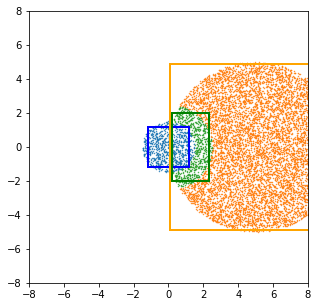

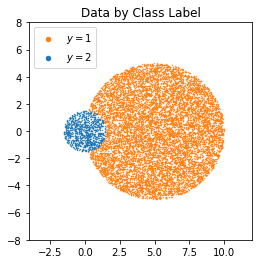

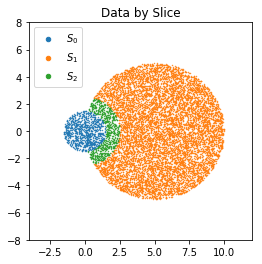

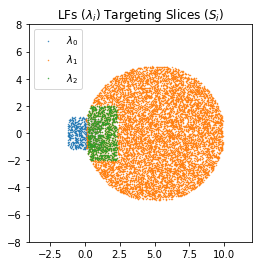

---------- Training EndModel ----------

Network architecture:
Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=5, out_features=2, bias=True)
)

No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 7.156	Dev accuracy: 0.926
[E:1]	Train Loss: 4.178	Dev accuracy: 0.926
[E:2]	Train Loss: 3.733	Dev accuracy: 0.956
[E:3]	Train Loss: 3.511	Dev accuracy: 0.969
[E:4]	Train Loss: 3.363	Dev accuracy: 0.973
Saving model at iteration 5 with best score 0.976
[E:5]	Train Loss: 3.248	Dev accuracy: 0.976
Saving model at iteration 6 with best score 0.977
[E:6]	Train Loss: 3.153	Dev accuracy: 0.977
Saving model at iteration 7 with best score 0.978
[E:7]	Train Loss: 3.074	Dev accuracy: 0.978
Saving model at iteration 8 with best score 0.979
[E:8]	Train Loss: 3.008	D

Saving model at iteration 0 with best score 0.980
[E:0]	Train Loss: 6.063	Dev accuracy: 0.980
[E:1]	Train Loss: 2.693	Dev accuracy: 0.979
Saving model at iteration 2 with best score 0.981
[E:2]	Train Loss: 2.556	Dev accuracy: 0.981
[E:3]	Train Loss: 2.441	Dev accuracy: 0.979
Saving model at iteration 4 with best score 0.989
[E:4]	Train Loss: 2.428	Dev accuracy: 0.989
[E:5]	Train Loss: 2.416	Dev accuracy: 0.977
[E:6]	Train Loss: 2.369	Dev accuracy: 0.983
[E:7]	Train Loss: 2.329	Dev accuracy: 0.987
[E:8]	Train Loss: 2.254	Dev accuracy: 0.989
[E:9]	Train Loss: 2.204	Dev accuracy: 0.983
Restoring best model from iteration 4 with score 0.989
Finished Training
Accuracy: 0.989
        y=1    y=2   
 l=1    962     6    
 l=2     5     71    
Accuracy: 0.989
        y=1    y=2   
 l=1    962     6    
 l=2     5     71    
Dev Score on L2 examples: 0.9894636015325671
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 2.158	Dev accuracy: 0.991
[E:1]	Trai

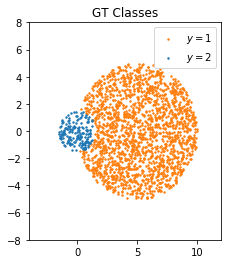

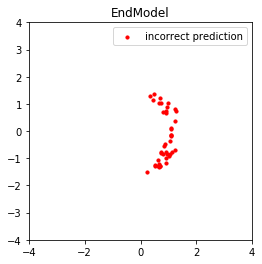

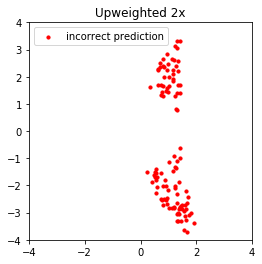

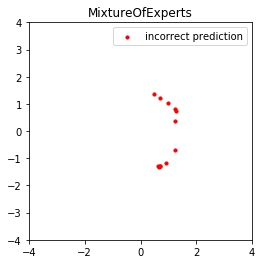

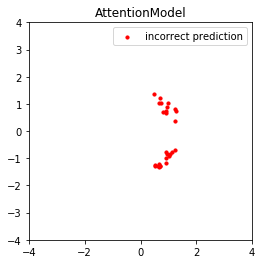

,EndModel,Upweighted 2x,MixtureOfExperts,AttentionModel
None: None,,,,
S0,0.769663,1.000000,0.932584,0.848315
S1,1.000000,0.970191,1.000000,1.000000
S2,0.992593,0.592593,1.000000,1.000000
overall,0.979914,0.948350,0.994261,0.987088


In [21]:
from simulate import simulate, experiment_config
# config['accs'] = np.array(accs)
experiment_config['use_weak_labels_from_gen_model'] = False
experiment_config['x_var'] = None
experiment_config['x_range'] = None
experiment_config['num_trials'] = 1
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['plot_predictions'] = True

experiment_config['seed'] = 333
scores = \
    simulate(config, generate_pacman_data, experiment_config, model_configs)
display_scores(scores, x_var=None, x_range=[None])